In [68]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import words
import re
import language_tool_python
from collections import Counter
from PIL import Image

import plotly.express as px
import plotly.figure_factory as ff
# import torch
# from transformers import PegasusForConditionalGeneration, PegasusTokenizer
# from transformers import T5Tokenizer, T5ForConditionalGeneration
# from transformers import GPT2Tokenizer, GPT2LMHeadModel
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
from plotly import graph_objs as go
from collections import defaultdict
import pandas as pd
from plotly import tools
from plotly.offline import iplot
from palettable.colorbrewer.qualitative import Pastel1_7



In [2]:
from Preprocess.data_cleaning import DataCleaning


## 1. Data exploration

In [3]:
df = pd.read_csv('C:/Users/iyadh/Desktop/hate_speech/Data/Ethos_Dataset_Binary.csv', sep=';')


In [4]:
df.head(4)

comment  isHate
0          You should know women's sports are a joke     1.0
1    You look like Sloth with deeper Down’s syndrome     1.0
2  You look like Russian and speak like Indian. B...     1.0
3               Women deserve to be abused, I guess.     1.0

In [5]:
df.shape

(998, 2)

In [6]:
df.columns

Index(['comment', 'isHate'], dtype='object')

In [7]:
df= df.rename(columns={'isHate': 'class'})

In [8]:
# Check class value counts (1 hate true , 2 neutral ,0 non hate)
#Were going to work with 1 and 0
df['class'].value_counts()

class
0.000000    354
1.000000    163
0.166667    106
0.833333    100
0.333333     80
0.500000     74
0.666667     70
0.250000      6
0.750000      6
0.857143      3
0.903846      2
0.400000      2
0.018868      2
0.966667      1
0.954545      1
0.973333      1
0.978261      1
0.983871      1
0.983607      1
0.945455      1
0.937500      1
0.678571      1
0.821429      1
0.603448      1
0.722222      1
0.846154      1
0.849057      1
0.296875      1
0.302326      1
0.530612      1
0.200000      1
0.111111      1
0.103448      1
0.160714      1
0.152542      1
0.038961      1
0.090909      1
0.037736      1
0.031746      1
0.029851      1
0.030303      1
0.026316      1
0.016393      1
Name: count, dtype: int64

In [9]:
#Apply clean_class_column  
df = DataCleaning.clean_class_column(df, 'class')


In [10]:
# Display clean_class_column result
df['class'].value_counts()

class
0                 565
1                 358
not considered     75
Name: count, dtype: int64

In [11]:
df

comment class
0            You should know women's sports are a joke     1
1      You look like Sloth with deeper Down’s syndrome     1
2    You look like Russian and speak like Indian. B...     1
3                 Women deserve to be abused, I guess.     1
4    Women are made for making babies and cooking d...     1
..                                                 ...   ...
993   From the midnight sun where the hot springs blow     0
994                        Don't say I'm not your type     0
995   And therefore never send to know for whom the...     0
996                      And I can't stand another day     0
997   All values, unless otherwise stated, are in U...     0

[998 rows x 2 columns]

In [12]:
df.shape

(998, 2)

In [13]:
df = df[df['class'].isin([0, 1])]


In [14]:
# Nombre de valeurs NaN dans la colonne 'comment'
nan_number = df['comment'].isna().sum()
print("Number of NaN values in the column 'comment' :", nan_number)

Number of NaN values in the column 'comment' : 0


In [15]:
df["class"].value_counts(normalize=True)

class
0    0.612134
1    0.387866
Name: proportion, dtype: float64

#####  On remarque que la class target is unbalanced so we must first treat this problem 
##### Also our data isn't that mush 998 so we must generate data
#####  TO adress this problem were going to use : 
 - use T5 model
 - use PEGASUS paraphraser model 
 - use GPT-2 model 
 - synonym replacement, random insertion, and random deletion
 - use smote before training (when splitting data)


##### But before generating new data we're gonna clean the data so that we can generate descent data (a common citation : garbage in garbage out)

In [16]:
# df.to_csv('./Data/hate_speech_merged_data.csv', index=False)

## 2. Data Perprocessing

##### Before generating new data we're going to preprocess our data

In [17]:
# Run this 
# Download the words corpus if not already downloaded
try:
    nltk.data.find('corpora/words')
except LookupError:
    nltk.download('words')

In [18]:
# Sample text to demonstrate each function
sample_text = " @user_name  Hello! 😊 Check     this out: http://example.com wont <p>This is a paragraph.</p> #example <i>Italic</i> &gt; 123abc [remove this]"

# Applying each function and printing the result
print("Original Text:", sample_text)
print("\nAfter removing links:", DataCleaning.remove_links(sample_text))
print("\nAfter removing special characters:", DataCleaning.remove_special_chars(sample_text))
print("\nAfter removing emojis:", DataCleaning.remove_emojis(sample_text))
print("\nAfter removing square brackets:", DataCleaning.remove_square_brackets(sample_text))
print("\nAfter removing hashtags:", DataCleaning.remove_hashtags(sample_text))
print("\nAfter removing spaces and newlines:", DataCleaning.remove_spaces_and_newlines(sample_text))
print("\nAfter removing words with numbers:", DataCleaning.remove_words_with_numbers(sample_text))
print("\nAfter removing HTML tags:", DataCleaning.remove_html_tags(sample_text))
print("\nAfter removing HTML entities:", DataCleaning.remove_html_entities(sample_text))
print("\nAfter removing specific tags:", DataCleaning.remove_specific_tags(sample_text))
print("\nAfter removing puunctuations:", DataCleaning.remove_punctuation(sample_text))
print("\nAfter removing spaces (example this     out):", DataCleaning.remove_unnecessary_spaces(sample_text))
print("\nAfter correcting abbreviations Ex wont : will not:", DataCleaning.expand_abbreviations(sample_text))
print("\nAfter removing users (@user_name : because we have some tweets in our data):", DataCleaning.remove_user_mentions(sample_text))

Original Text:  @user_name  Hello! 😊 Check     this out: http://example.com wont <p>This is a paragraph.</p> #example <i>Italic</i> &gt; 123abc [remove this]

After removing links:  @user_name  Hello! 😊 Check     this out:  wont <p>This is a paragraph.</p> #example <i>Italic</i> &gt; 123abc [remove this]

After removing special characters:  user_name  Hello  Check     this out httpexamplecom wont pThis is a paragraphp example iItalici gt 123abc remove this

After removing emojis:  @user_name  Hello!  Check     this out: http://example.com wont <p>This is a paragraph.</p> #example <i>Italic</i> &gt; 123abc [remove this]

After removing square brackets:  @user_name  Hello! 😊 Check     this out: http://example.com wont <p>This is a paragraph.</p> #example <i>Italic</i> &gt; 123abc 

After removing hashtags:  @user_name  Hello! 😊 Check     this out: http://example.com wont <p>This is a paragraph.</p>  <i>Italic</i> &gt; 123abc [remove this]

After removing spaces and newlines:  @user_name 

In [19]:
# Test detect out of vocabulary words 
test_texts = [
        "Hello world rt",
        "Supercalifragilisticexpialidocious is a fantabulous word",
        "I like to program in Python and xzqwk"
    ]
    
for text in test_texts:
    result = DataCleaning.display_oov_words(text)
    print('Original text :',text )
    print(f"OOV words: {result['oov_words']}")
    print(f"Number of OOV words: {result['oov_count']}")
    print('\n')


Original text : Hello world rt
OOV words: ['rt']
Number of OOV words: 1


Original text : Supercalifragilisticexpialidocious is a fantabulous word
OOV words: ['supercalifragilisticexpialidocious', 'fantabulous']
Number of OOV words: 2


Original text : I like to program in Python and xzqwk
OOV words: ['xzqwk']
Number of OOV words: 1




In [20]:
# Grammatical errors corrections

tool = language_tool_python.LanguageTool('en-US', remote_server='https://api.languagetool.org')

test_texts = [
        "She go to school everyday but forget her books",
        "He dont likes to plays with they",
        "The cats was chaseing mouses in the yard",
        "I seen him yesterday and he look tired",
        "This are a beautifull day for picnic"
    ]
    
for text in test_texts:
    corrected = DataCleaning.correct_grammar(text)
    print(f"\nOriginal: {text}")
    print(f"Grammar corrected: {corrected}")
    
    # Close the language tool when done
    tool.close()


Original: She go to school everyday but forget her books
Grammar corrected: She goes to school every day but forget her books

Original: He dont likes to plays with they
Grammar corrected: He don't likes to plays with them

Original: The cats was chaseing mouses in the yard
Grammar corrected: The cats were chasing mouses in the yard

Original: I seen him yesterday and he look tired
Grammar corrected: I have seen him yesterday and he looks tired

Original: This are a beautifull day for picnic
Grammar corrected: These is a beautiful day for picnic


##### We have defined preprocess_text functiouns that does all the step above and werre going to call it 

In [21]:
df['cleaned_comment'] = df['comment'].apply(DataCleaning.preprocess_text)

In [22]:
df.head(2)

comment class  \
0        You should know women's sports are a joke     1   
1  You look like Sloth with deeper Down’s syndrome     1   

                                  cleaned_comment  
0        you should know womens sports are a joke  
1  you look like sloth with deeper downs syndrome

## DataCleaning Class Steps

### 1. Initialization
- **Imports** : `re`, `pandas`, `string`, `nltk`, `language_tool_python`
- **NLTK Corpus**: Downloads `words` corpus if not present
- **Language Tool**: Initializes with remote server `https://api.languagetool.org`
- **Abbreviations**: Defines a dictionary of common abbreviations

### 2. Text Cleaning Methods

#### remove_links
- **Action**: Removes URLs (http/www)
- **Regex**: `r'http\S+|www\S+'`

#### remove_user_mentions
- **Action**: Removes @mentions
- **Regex**: `r'@\w+'`

#### remove_html_tags
- **Action**: Removes HTML tags
- **Regex**: `r'<.*?>+'`

#### remove_html_entities
- **Action**: Cleans HTML entities (>, ', /)
- **Regex**: Multiple `re.sub` calls

#### remove_specific_tags
- **Action**: Removes specific tags  
- **Regex**: Tag-specific patterns

#### remove_special_chars
- **Action**: Removes special characters
- **Regex**: `r'[^\w\s]'`

#### remove_emojis
- **Action**: Removes Unicode emojis
- **Regex**: Emoji range pattern

#### remove_square_brackets
- **Action**: Removes text in square brackets
- **Regex**: `r'\[.*?\]'`

#### remove_hashtags
- **Action**: Removes hashtags
- **Regex**: `r'#\w+'`

#### remove_spaces_and_newlines
- **Action**: Removes tabs and newlines
- **Method**: `replace("\t", "").replace("\n", "")`

#### remove_words_with_numbers
- **Action**: Removes words with digits
- **Regex**: `r'\w*\d\w*'`

#### remove_punctuation
- **Action**: Replaces punctuation with spaces
- **Method**: `translate` with `string.punctuation`

#### remove_unnecessary_spaces
- **Action**: Normalizes multiple spaces to single
- **Regex**: `r'\s+'`

#### expand_abbreviations
- **Action**: Expands abbreviations using dictionary
- **Method**: List comprehension with `ABBREVIATIONS`

#### correct_grammar
- **Action**: Corrects grammar
- **Tool**: `language_tool_python`
- **Fallback**: Returns original text on error

#### detect_oov_words
- **Action**: Removes OOV words
- **Uses**: NLTK `words` corpus
- **Returns**: Cleaned text

### 3. Main Preprocessing Pipeline (preprocess_text)
1. Convert to lowercase
2. Remove links
3. Remove user mentions
4. Remove HTML tags
5. Remove HTML entities
6. Remove specific tags
7. Remove special characters
8. Remove emojis
9. Remove square brackets
10. Remove hashtags
11. Expand abbreviations
12. Remove spaces/newlines
13. Remove words with numbers
14. Remove punctuation
15. Remove OOV words
16. Grammar correction
17. Remove unnecessary spaces 


## 3. Data augmentation

### This code is just an explanation since we don't have cuda we're going to run the code on cloab and the notebooks will be uploaded to colab_notebooks folder

In [26]:

model_name = "t5-large"  # Or "t5-base" or "t5-large"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [27]:
def paraphrase_text(text, num_return_sequences=3):
    input_text = f"Rephrase this text: {text.lower()}"  # Convert the input text to lowercase
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
    outputs = model.generate(
        inputs["input_ids"],
        max_length=20,
        num_return_sequences=num_return_sequences,  # Generate multiple paraphrases
        do_sample=True,  # Enable sampling for diversity
        top_k=50,
        top_p=0.95,
        no_repeat_ngram_size=2  # Prevents repeating 2-word sequences
    )
    paraphrases = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    
    # Convert the paraphrases to lowercase and remove the lowercase version of the prompt
    paraphrases = [paraphrase.replace("rephrase", "").strip().lower() for paraphrase in paraphrases]
    
    return paraphrases



In [28]:
# Test 
sample_text = "white people are shit human beings"
paraphrases = paraphrase_text(sample_text)
# print(f"Original: {sample_text}")
# print(f"Paraphrases: {paraphrases}")

In [41]:
# Test 
sample_text = "white people are shit human beings"
paraphrases = paraphrase_text(sample_text)
# print(f"Original: {sample_text}")
# print(f"Paraphrases: {paraphrases}")

In [29]:
print(f"Paraphrases: {paraphrases}")

Paraphrases: [': white people are shit.,. get this:.', ': "white people are shit.". white people can\'t be', ': white people are shit human beings.. and. white']


In [42]:
# peagsus paraphraser generation function
model_name = 'tuner007/pegasus_paraphrase'
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(torch_device)

def get_response(input_text,num_return_sequences,num_beams):
  batch = tokenizer([input_text],truncation=True,padding='longest',max_length=60, return_tensors="pt").to(torch_device)
  translated = model.generate(**batch,max_length=60,num_beams=num_beams, num_return_sequences=num_return_sequences, temperature=1.5)
  tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
  return tgt_text

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
num_beams = 10
num_return_sequences = 10

In [44]:
response=get_response("white people are shit human beings",num_return_sequences,num_beams)
response

['White people are not human beings.',
 'White people are scum.',
 'White people are not human.',
 'White people are not good people.',
 'White people are stupid.',
 'White people are dumb.',
 'People of white colour are not human beings.',
 'White people are not nice.',
 'People who are white are scum.',
 'People who are white are not human beings.']

In [45]:
#Another example
response=get_response("i love this movie",num_return_sequences,num_beams)
response

['I like this movie.',
 'I really like this movie.',
 'I enjoy this movie.',
 'I like this movie a lot.',
 'I love this movie.',
 'I like this film.',
 'I like the movie.',
 'I love the movie.',
 'I think this movie is great.',
 'This is a movie I really like.']

In [ ]:
# augmented_data = []
# for text in minority_data:
#     paraphrases = paraphrase_text(text, num_return_sequences=2)  # Generate 2 new samples per original
#     augmented_data.extend([(para, minority_class) for para in paraphrases])

# # Convert to dataframe
# augmented_df = pd.DataFrame(augmented_data, columns=['comment', 'label'])

In [47]:

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

def generate_text(text, max_length=20, num_samples=5):
    prompt = f"Parphrase this text: {text}"  # Clearer phrasing for paraphrasing
    inputs = tokenizer(prompt, return_tensors="pt")
    
    # Generate multiple samples
    outputs = model.generate(inputs["input_ids"], max_length=max_length, do_sample=True, top_k=50, num_return_sequences=num_samples)
    
    # Decode and return all the generated samples
    return [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

# Example usage
text = "i love you"
generated_samples = generate_text(text)

# Print all generated samples
for i, sample in enumerate(generated_samples, 1):
    print(f"Sample {i}: {sample}")


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 1: Parphrase this text: i love you, kiddo I'm a real good and genuine person
Sample 2: Parphrase this text: i love you, i love you for being an adult. You have an
Sample 3: Parphrase this text: i love you

This is a picture of my cat in a ball
Sample 4: Parphrase this text: i love you a lot but you think you won't feel like a woman
Sample 5: Parphrase this text: i love you;

i like you

i love you



##### As we can see the models are generating some decent data especially Pegasus so we're going to mainly focus on data generated from Pegasus
##### Since we dont have cuda were going to run in colab and u can find the notebooks in folder colab notebooks


# 4. Data visulaisation

In [23]:
df.describe()


comment  class  \
count                                                 923    923   
unique                                                923      2   
top      All values, unless otherwise stated, are in U...      0   
freq                                                    1    565   

                                          cleaned_comment  
count                                                 923  
unique                                                921  
top     i do not see why we do not just create a trans...  
freq                                                    2

In [24]:
temp = df.groupby('class').count()['cleaned_comment'].reset_index().sort_values(by='cleaned_comment',ascending=False)
temp.style.background_gradient(cmap='Purples')

In [25]:
fig = go.Figure(go.Funnelarea(
    text=temp['class'],  # Utilisation correcte de la colonne
    values=temp['cleaned_comment'],  # Assurez-vous que 'text' est bien une colonne numérique
    title={"position": "top center", "text": "Funnel-Chart of Hate Speech Distribution"}
))

fig.show()

In [27]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\iyadh\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [28]:
# Load full stopword list
STOPWORDS = set(stopwords.words('english'))

# Split cleaned_comment into words and remove stopwords
df['temp_list'] = df['cleaned_comment'].apply(lambda x: [word for word in str(x).split() if word.lower() not in STOPWORDS])

# Count word frequencies
top = Counter([item for sublist in df['temp_list'] for item in sublist])

# Convert to DataFrame
temp = pd.DataFrame(top.most_common(20), columns=['Common_words', 'count'])

# Apply styling
temp.style.background_gradient(cmap='Blues')

In [29]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in all data', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [30]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

## Common words for hate speech

In [33]:
# Filter rows where class is 1 (Hate Speech)
df_class_1 = df[df['class'] == 1]

# Remove stopwords from the tokenized words
df_class_1['temp_list'] = df_class_1['cleaned_comment'].apply(lambda x: [word for word in str(x).split() if word.lower() not in STOPWORDS])

# Count word frequencies
top = Counter([item for sublist in df_class_1['temp_list'] for item in sublist])

# Convert to DataFrame
temp = pd.DataFrame(top.most_common(20), columns=['Common_words', 'count'])

# Apply styling
temp.style.background_gradient(cmap='Blues')

In [34]:
fig = px.treemap(temp, path=['Common_words'], values='count', title='Tree Of Most Common Words for hate speech')
fig.show()


# Common words for non hate speech

In [35]:
# Filter rows where class is 1 (Hate Speech)
df_class_2 = df[df['class'] == 0]

# Remove stopwords from the tokenized words
df_class_2['temp_list'] = df_class_2['cleaned_comment'].apply(lambda x: [word for word in str(x).split() if word.lower() not in STOPWORDS])

# Count word frequencies
top = Counter([item for sublist in df_class_2['temp_list'] for item in sublist])

# Convert to DataFrame
temp = pd.DataFrame(top.most_common(20), columns=['Common_words', 'count'])

# Apply styling
temp.style.background_gradient(cmap='Blues')

In [36]:
fig = px.treemap(temp, path=['Common_words'], values='count', title='Tree Of Most Common Words for non hate speech')
fig.show()


In [40]:
# Filtering data based on sentiment class (1 for positive, 0 for negative)
df_pos = df[df["class"] == 1].dropna()  # Positive (Hate speech)
df_neg = df[df["class"] == 0].dropna()  # Negative (No hate speech)

## Custom function for n-gram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## Custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation='h',
        marker=dict(
            color=color,
        ),
    )
    return trace

# Get the bar chart from positive comments (Hate speech)
freq_dict = defaultdict(int)
for sent in df_pos["cleaned_comment"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

# Get the bar chart from negative comments (No hate speech)
freq_dict = defaultdict(int)
for sent in df_neg["cleaned_comment"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words in hate speech comment", "Frequent words in non-hate speech comment"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)

# Update layout
fig['layout'].update(height=1000, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots for Hate Speech and Non-Hate Speech")
iplot(fig, filename='word-plots')


In [41]:
# Filtering data based on sentiment class (1 for positive, 0 for negative)
df_pos = df[df["class"] == 1].dropna()  # Positive (Hate speech)
df_neg = df[df["class"] == 0].dropna()  # Negative (No hate speech)

## Custom function for n-gram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## Custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation='h',
        marker=dict(
            color=color,
        ),
    )
    return trace

# Get the bar chart from positive comment (Hate speech) with bigrams
freq_dict = defaultdict(int)
for sent in df_pos["cleaned_comment"]:
    for word in generate_ngrams(sent, 2):  # Using bigrams
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

# Get the bar chart from negative comment (No hate speech) with bigrams
freq_dict = defaultdict(int)
for sent in df_neg["cleaned_comment"]:
    for word in generate_ngrams(sent, 2):  # Using bigrams
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'brown')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.04, horizontal_spacing=0.25,
                          subplot_titles=["Bigram plots of Hate Speech comment", 
                                          "Bigram plots of Non-Hate Speech comment"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)

# Update layout
fig['layout'].update(height=1000, width=800, paper_bgcolor='rgb(233,233,233)', title="Bigram Plots for Hate Speech vs Non-Hate Speech")
iplot(fig, filename='bigram-plots')


In [42]:

# Filtering data based on sentiment class (1 for positive, 0 for negative)
df_pos = df[df["class"] == 1].dropna()  # Positive (Hate speech)
df_neg = df[df["class"] == 0].dropna()  # Negative (No hate speech)

## Custom function for n-gram generation ##
def generate_ngrams(text, n_gram=3):  # Change to 3 for trigrams
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## Custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation='h',
        marker=dict(
            color=color,
        ),
    )
    return trace

# Get the bar chart from positive comments (Hate speech) with trigrams
freq_dict = defaultdict(int)
for sent in df_pos["cleaned_comment"]:
    for word in generate_ngrams(sent, 3):  # Using trigrams
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

# Get the bar chart from negative comments (No hate speech) with trigrams
freq_dict = defaultdict(int)
for sent in df_neg["cleaned_comment"]:
    for word in generate_ngrams(sent, 3):  # Using trigrams
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'brown')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.04, horizontal_spacing=0.25,
                          subplot_titles=["Trigram plots of Hate Speech comments", 
                                          "Trigram plots of Non-Hate Speech comments"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)

# Update layout
fig['layout'].update(height=1000, width=800, paper_bgcolor='rgb(233,233,233)', title="Trigram Plots for Hate Speech vs Non-Hate Speech")
iplot(fig, filename='trigram-plots')


In [43]:
from collections import Counter
import pandas as pd
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Load full stopword list
STOPWORDS = set(stopwords.words('english'))

def words_unique(sentiment, numwords, raw_words, df):
    """
    Identifies words unique to a specific sentiment class in the dataset.

    Parameters:
        sentiment (int): Sentiment class (1 for hate speech, 0 for non-hate speech)
        numwords (int): Number of unique words to display
        raw_words (list): List of words from the specific sentiment class
        df (DataFrame): The dataset containing 'class' and 'cleaned_comment' columns

    Returns:
        DataFrame: Unique words with their frequencies in descending order
    """
    # Get all words from other sentiment classes
    all_other = []
    for item in df[df['class'] != sentiment]['cleaned_comment']:
        for word in str(item).split():
            all_other.append(word.lower())

    all_other = set(all_other)  # Unique words from other classes

    # Get words unique to the chosen sentiment class
    specific_only = [word for word in raw_words if word.lower() not in all_other and word.lower() not in STOPWORDS]

    mycounter = Counter()

    for item in df[df['class'] == sentiment]['cleaned_comment']:
        for word in str(item).split():
            if word.lower() in specific_only:
                mycounter[word.lower()] += 1

    # Convert to DataFrame and return the top words
    unique_words = pd.DataFrame(mycounter.most_common(numwords), columns=['words', 'count'])
    
    return unique_words


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\iyadh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [58]:
raw_text = [word for word_list in df['cleaned_comment'] for word in str(word_list).split()]
Unique_Positive = words_unique(0, 20, raw_text, df)

print("The top 20 unique words in Non Hate Speech are:")
Unique_Positive.style.background_gradient(cmap='Greens')


The top 20 unique words in Non Hate Speech are:


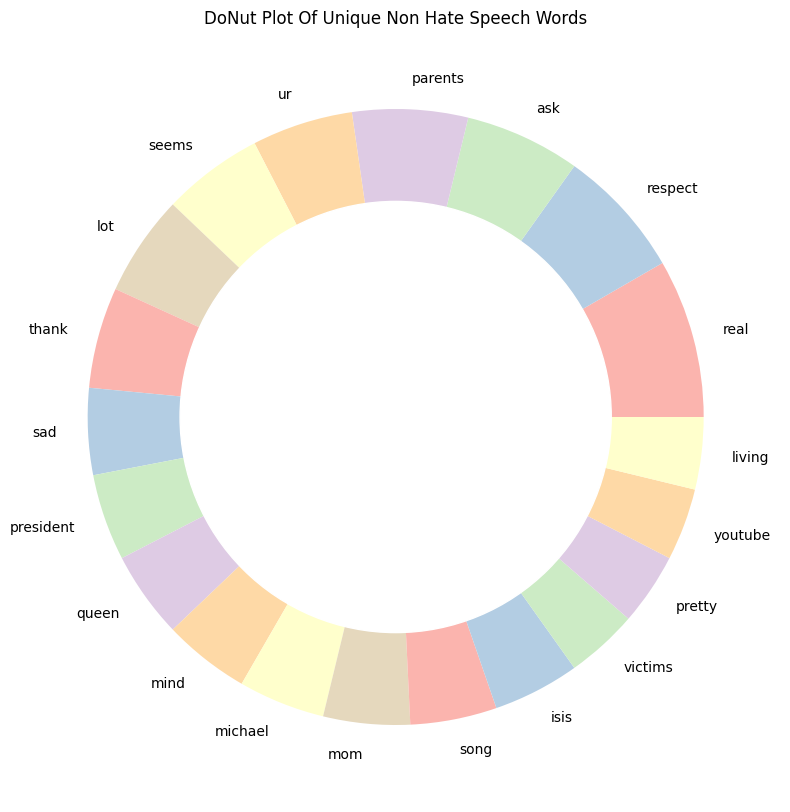

In [62]:
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Positive['count'], labels=Unique_Positive.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Non Hate Speech Words')
plt.show()

In [63]:
raw_text = [word for word_list in df['cleaned_comment'] for word in str(word_list).split()]
Unique_Negative = words_unique(1, 20, raw_text, df)

print("The top 20 unique words in Hate Speech are:")
Unique_Positive.style.background_gradient(cmap='Greens')


The top 20 unique words in Hate Speech are:


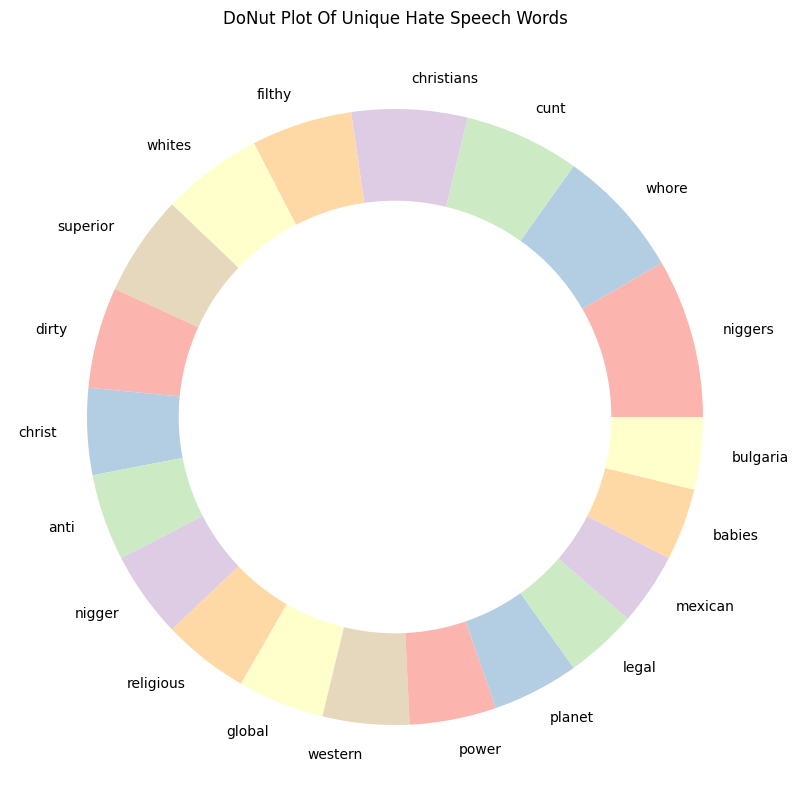

In [64]:
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Positive['count'], labels=Unique_Negative.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Hate Speech Words')
plt.show()

## Word count 

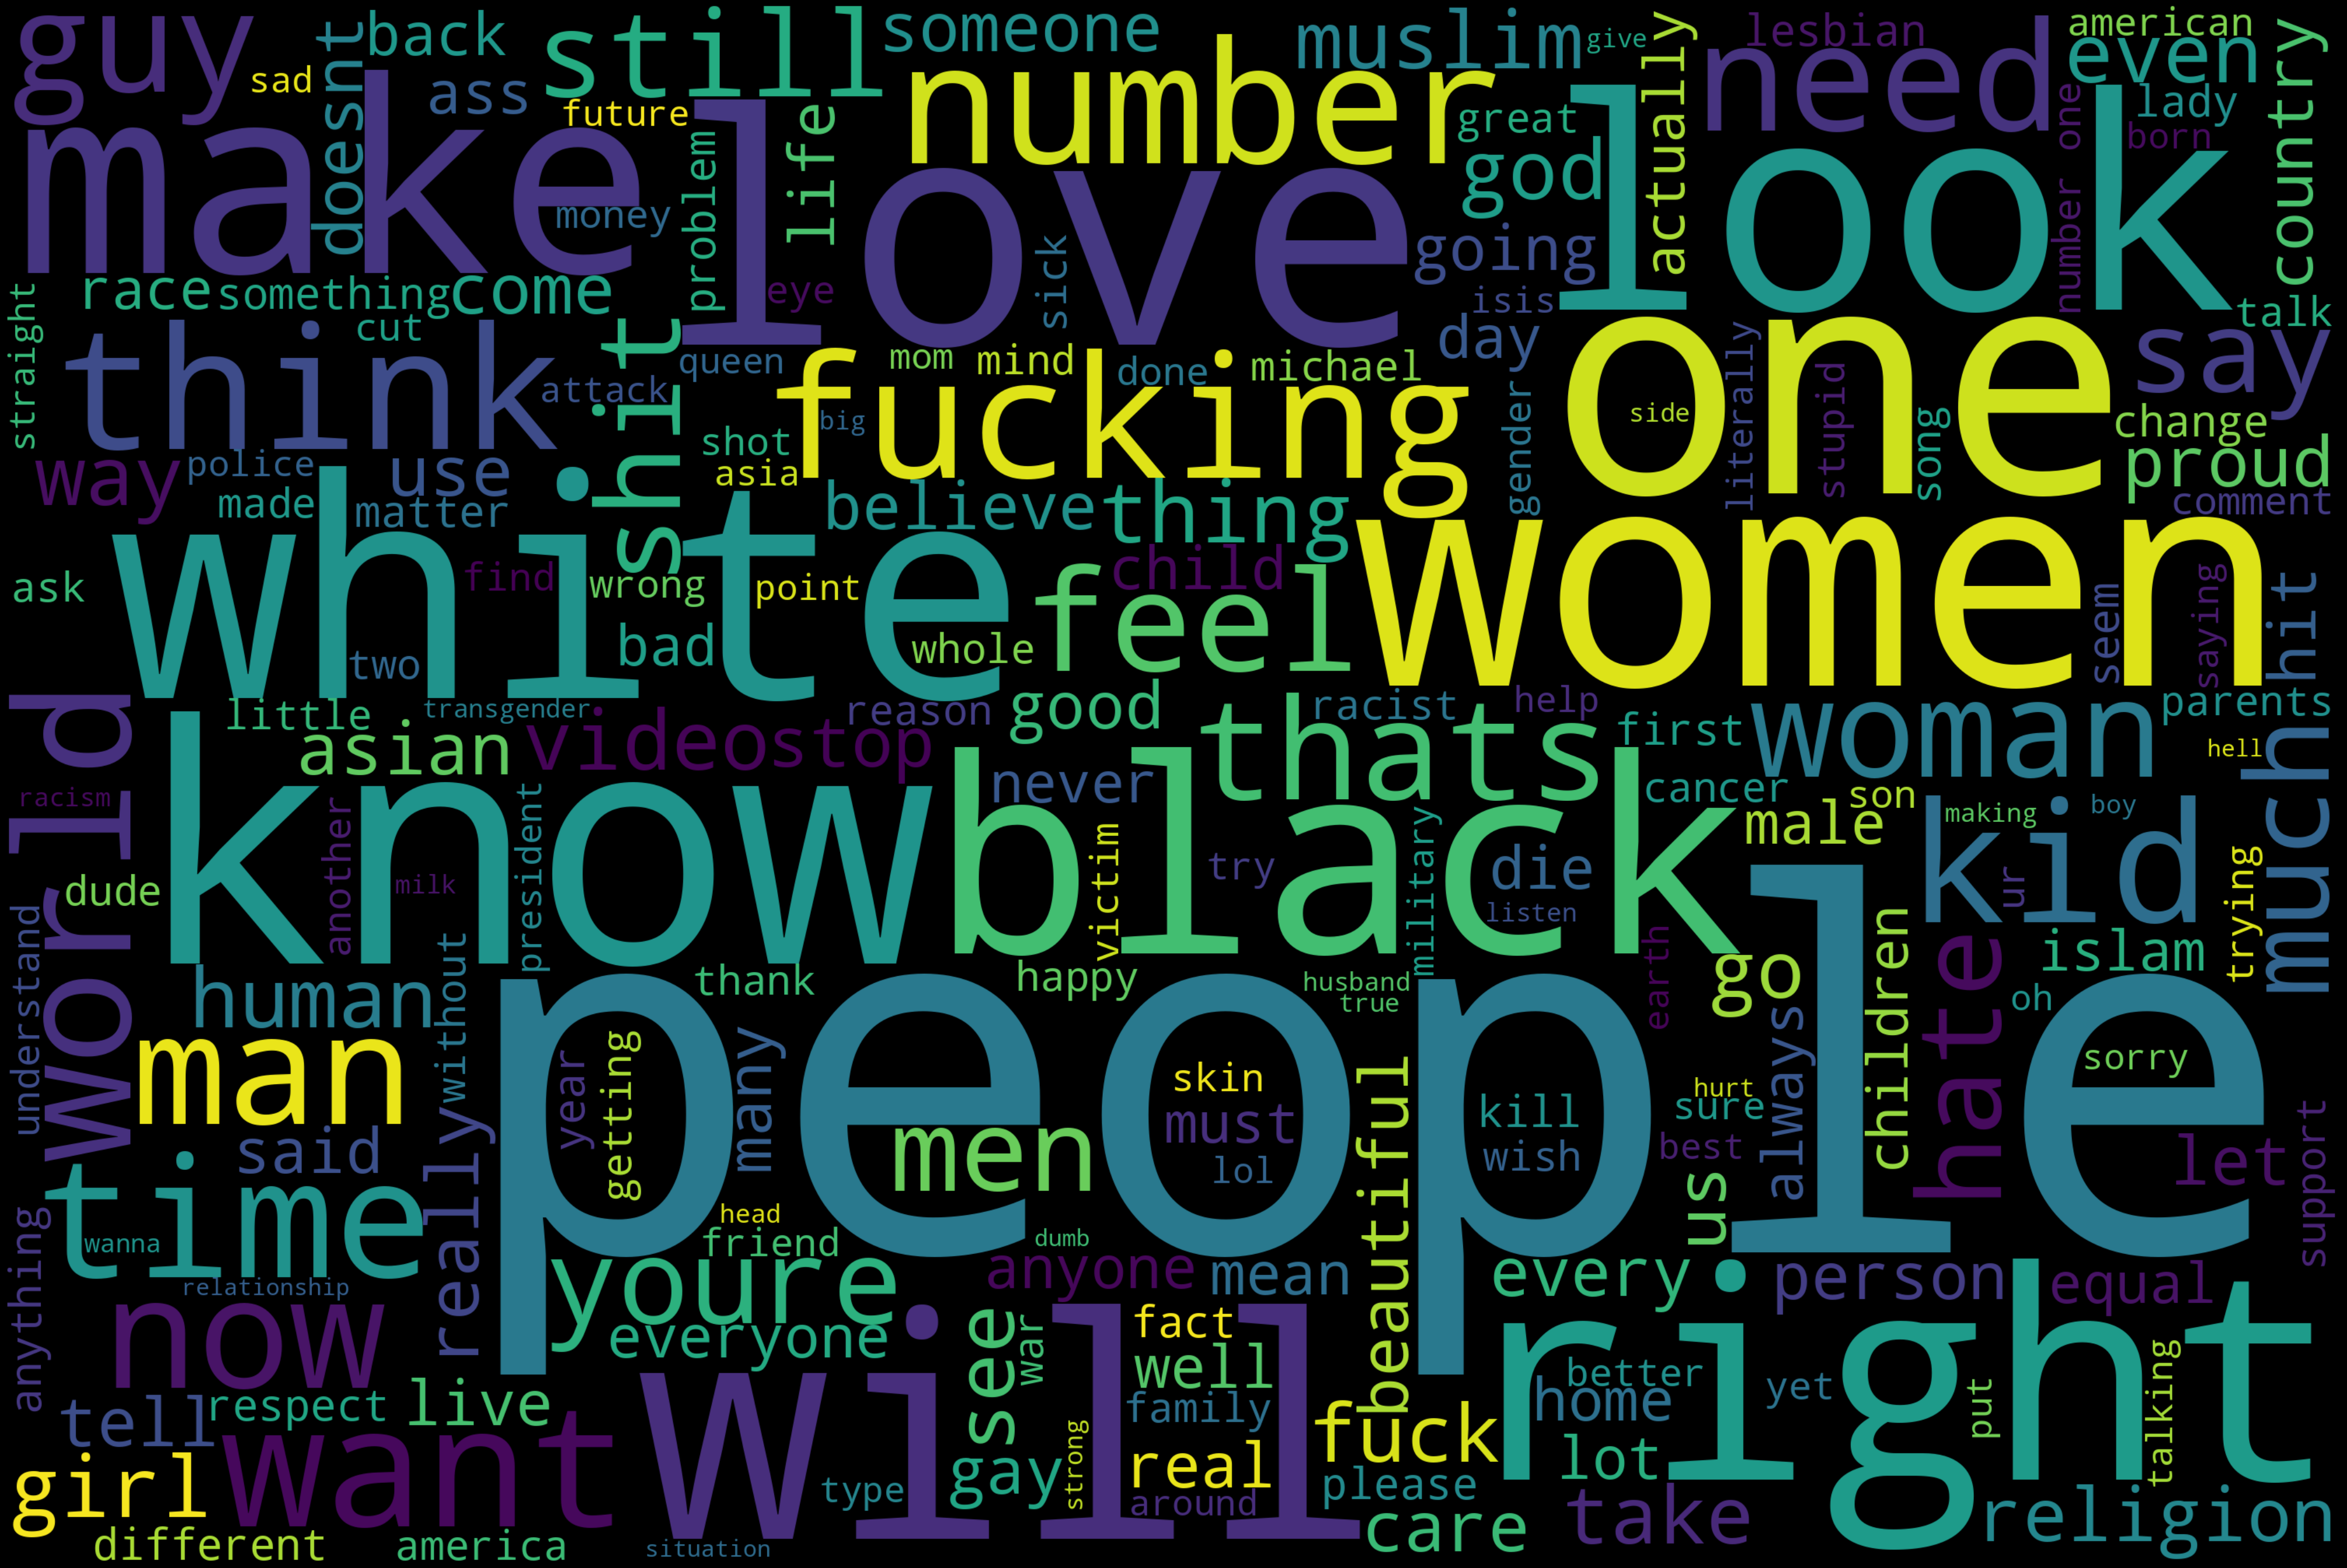

In [65]:
text = df[df["class"] == 0]["cleaned_comment"]  # Filtrer uniquement les commentaires de classe 0

wordcloud = WordCloud(
    width=3000,
    height=2000,
    background_color='black',
    stopwords=STOPWORDS
).generate(" ".join(text.astype(str)))  # Convertir en chaîne avant de générer le WordCloud

fig = plt.figure(
    figsize=(40, 30),
    facecolor='k',
    edgecolor='k'
)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


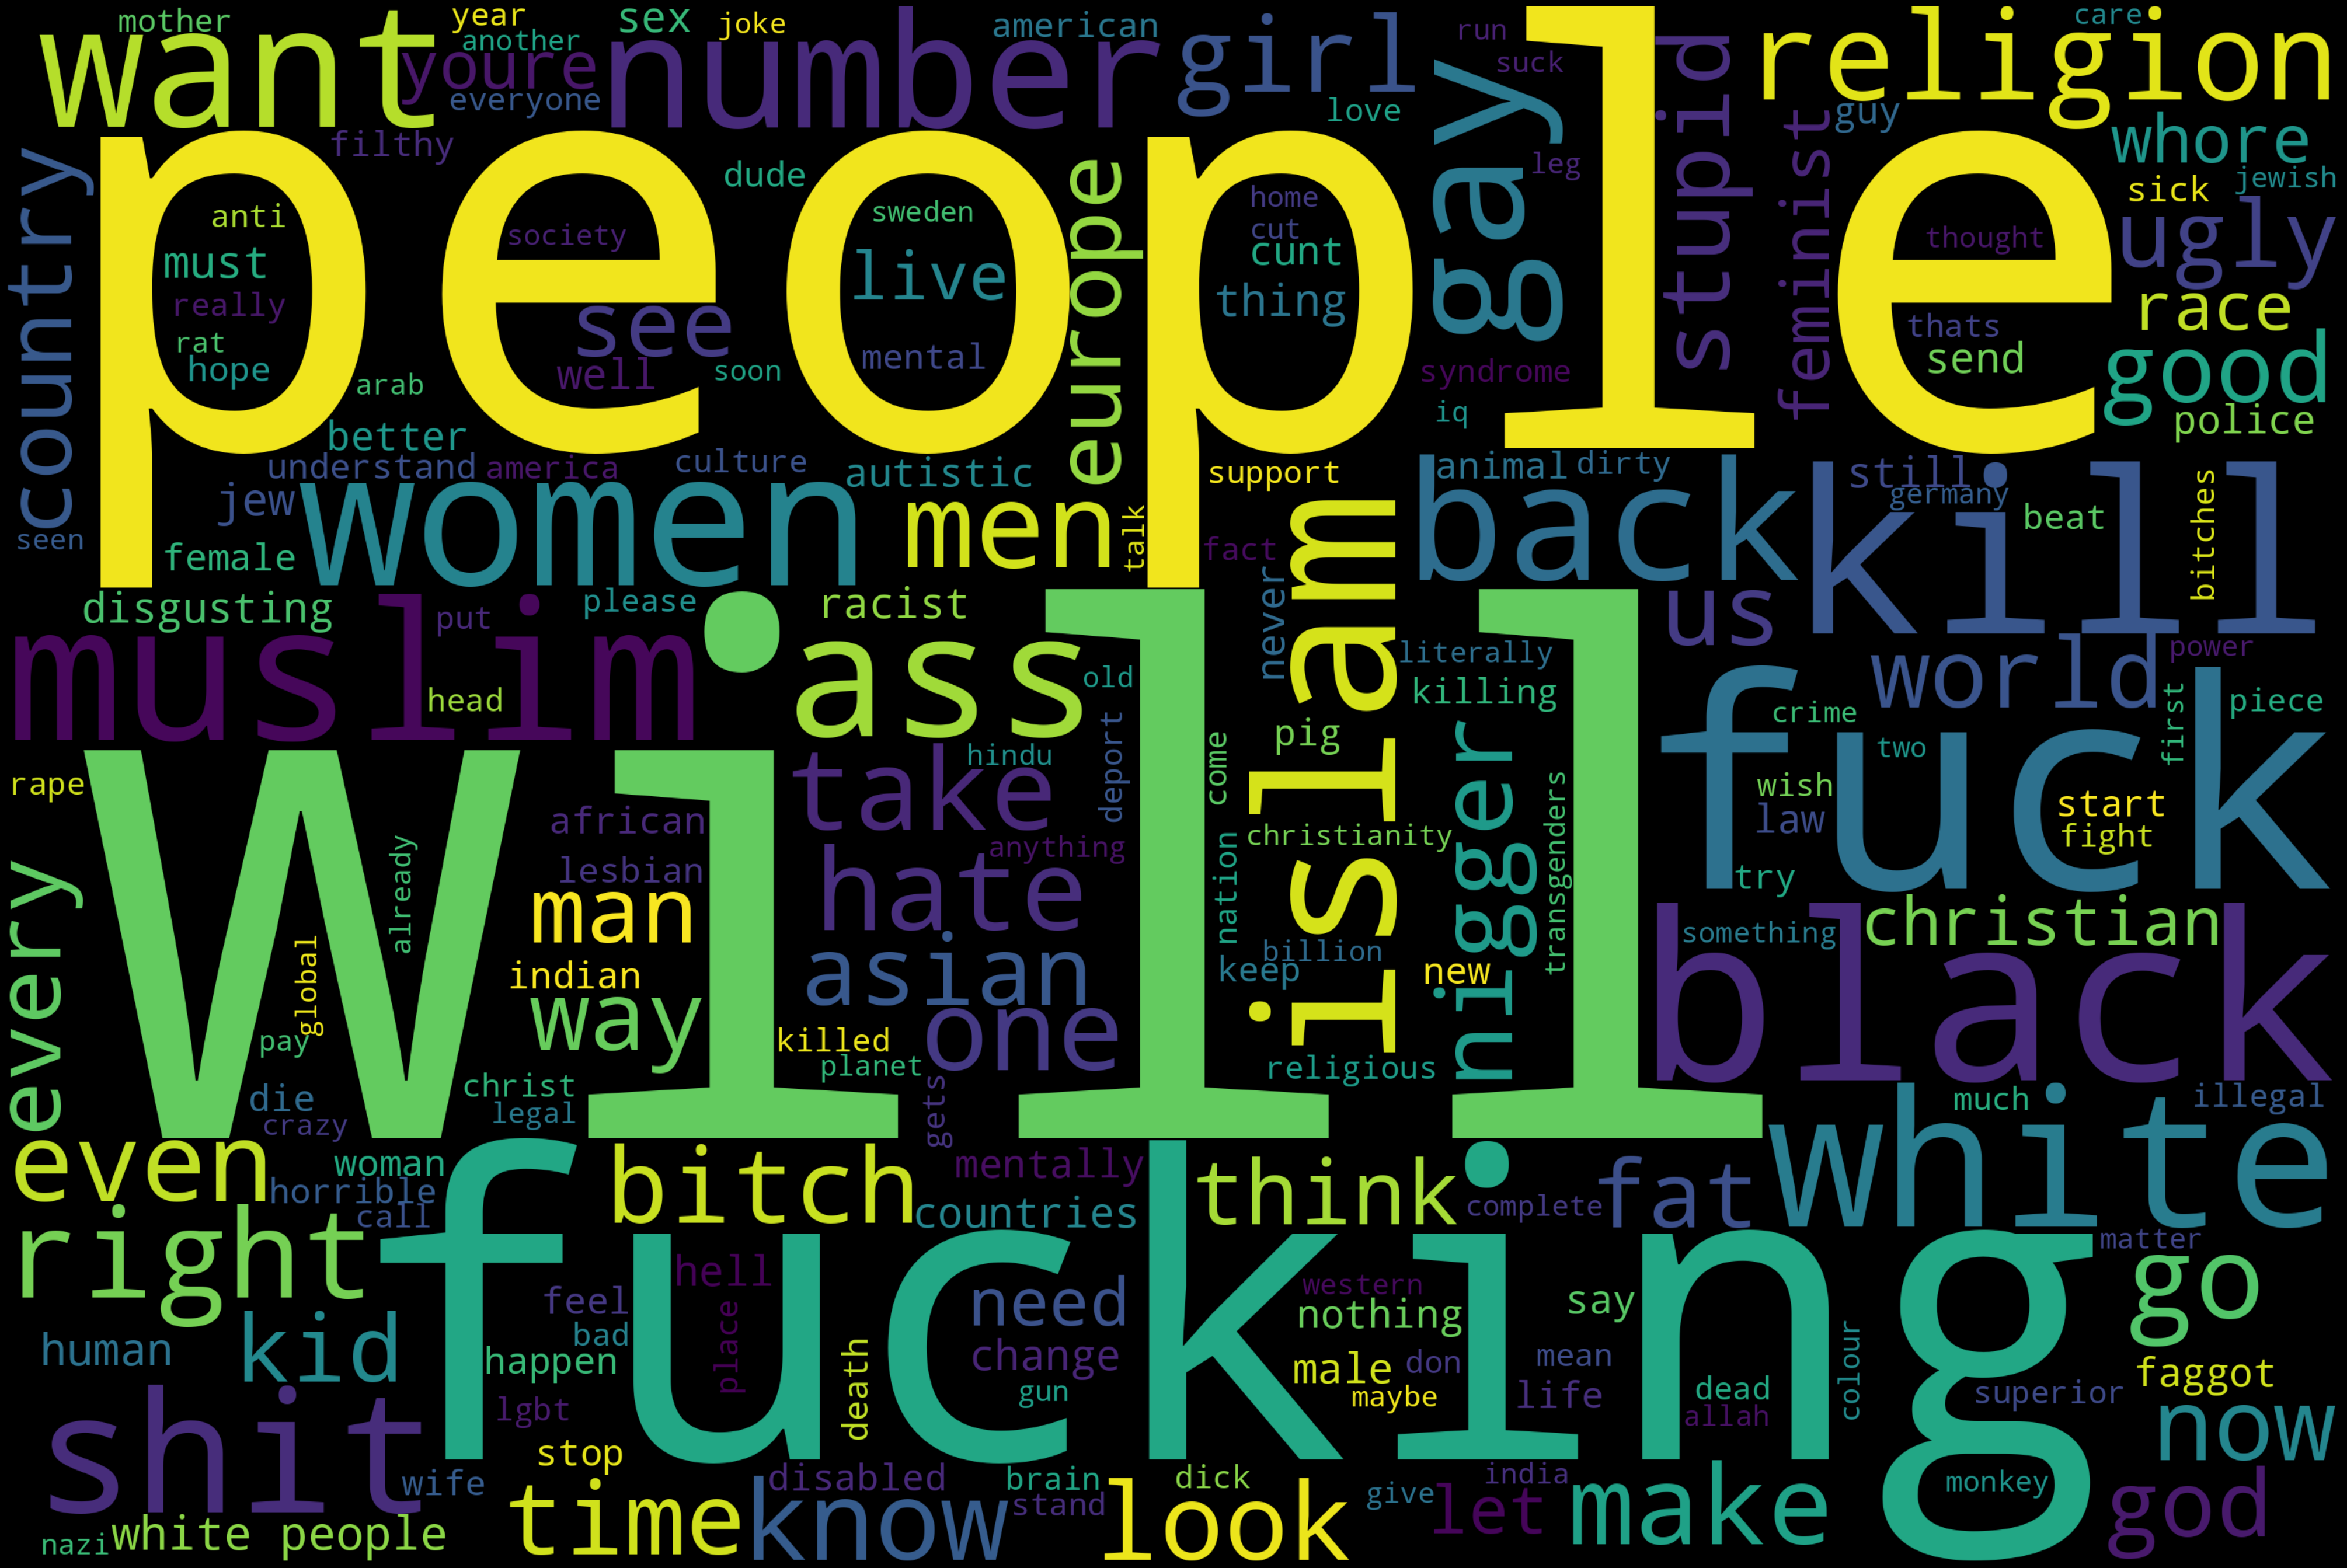

In [75]:
text = df[df["class"] == 1]["cleaned_comment"]  # Filtrer uniquement les commentaires de Hate

wordcloud = WordCloud(
    width=3000,
    height=2000,
    background_color='black',
    stopwords=STOPWORDS
).generate(" ".join(text.astype(str)))  # Convertir en chaîne avant de générer le WordCloud

fig = plt.figure(
    figsize=(40, 30),
    facecolor='k',
    edgecolor='k'
)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


In [80]:
from textblob import TextBlob
import cufflinks as cf



In [90]:
df['polarity'] = df['cleaned_comment'].map(lambda text: TextBlob(text).sentiment.polarity)
df['review_len'] = df['cleaned_comment'].astype(str).apply(len)
df['word_count'] = df['cleaned_comment'].apply(lambda x: len(str(x).split()))

In [89]:
# Create a histogram using Plotly Express
fig = px.histogram(df, 
                   x='polarity', 
                   nbins=50, 
                   title='Sentiment Polarity Distribution',
                   labels={'polarity': 'Polarity', 'count': 'Count'},
                   color_discrete_sequence=['blue'])  # Set bar color to blue

# Customize the line (border) color of the bars
fig.update_traces(marker=dict(line=dict(color='black', width=1)))

# Show the plot
fig.show()

In [92]:
import plotly.express as px

# Créer un histogramme avec Plotly Express
fig = px.histogram(df, 
                   x='review_len', 
                   nbins=100, 
                   title='Review Text Length Distribution',
                   labels={'review_len': 'Review Length', 'count': 'Count'},
                   color_discrete_sequence=['blue'])  # Couleur des barres

# Personnaliser la couleur de la bordure des barres
fig.update_traces(marker=dict(line=dict(color='black', width=1)))

# Afficher le graphique
fig.show()

In [93]:

# Créer un histogramme avec Plotly Express
fig = px.histogram(df, 
                   x='word_count', 
                   nbins=100, 
                   title='Review Text Word Count Distribution',
                   labels={'word_count': 'Word Count', 'count': 'Count'},
                   color_discrete_sequence=['blue'])  # Couleur des barres

# Personnaliser la couleur de la bordure des barres
fig.update_traces(marker=dict(line=dict(color='black', width=1)))

# Afficher le graphique
fig.show()